# 텍스트 감정 분석 실습

- 텍스트 감정분석의 유용성
- 텍스트 데이터를 통해 얻을 수 있는 정보와 활용에 대해 살펴봅니다.
- 텍스트 데이터의 특징
- 텍스트 데이터의 특징 (1) 텍스트를 숫자로 표현하는 방법
- 텍스트 데이터의 특징 (2) Embedding 레이어의 등장
- 시퀀스 데이터를 다루는 RNN
- 시퀀스 데이터와 RNN의 구조에 대해 알아봅니다.
- 꼭 RNN이어야 할까?
- 실습과 함께 RNN의 효율성에 대해 살펴봅니다.
- IMDB 영화리뷰 감성분석 (1) IMDB 데이터셋 분석
- IMDB 영화리뷰 감성분석 (2) 딥러닝 모델 설계와 훈련
- IMDB 영화리뷰 감성분석 (3) Word2Vec의 적용

## 중점으로 생각해볼 것

- 텍스트를 어떻게 숫자 행렬로 표현할 수 있을까
- 텍스트에는 순서가 중요한데, 입력 데이터의 순서를 인공지능 모델에 어떻게 반영할까

# 1. 텍스트를 숫자로 표현해보자 : 딕셔너리를 활용(단어사전)

In [3]:
 # 처리해야 할 문장을 파이썬 리스트에 옮겨 담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [4]:
index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [6]:
# 딕셔너리의 키 - value 교환

word_to_index={word:index for index, word in index_to_word.items()}

- 단어 인코딩: 1개 문장 + 여러개문장

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. -> 단어사전에 없는 것은 2로 간주.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [8]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


- 단어 디코딩: 1개문장 vs 여러문장

In [9]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [10]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


## 단어 사전은 입력으로는 사용가능하나 의미를 담기에는 충분하지 않다. 따라서 단어의 의미를 나타내는 벡터를 딥러닝을 통해 학습한다! -> embedding 레이어를 사용

In [12]:
import numpy as np
import tensorflow as tf
import os

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
# 인풋이될 텍스트 데이터의 벡터길이는 일정해야한다 -> keras.preprocessing함수 사용(<pad>를 추가하면 길이가 5로 일정해진다)
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                           value=word_to_index['<PAD>'],
                                                           padding='post',
                                                           maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[-4.9334228e-02 -3.6393654e-02 -3.6757160e-02  1.9883487e-02]
  [ 3.6218848e-02 -4.0630326e-03 -4.5500923e-02 -2.4066186e-02]
  [ 2.7092900e-02  1.2248136e-02 -4.2742457e-02  4.5592848e-02]
  [-5.7365671e-03  4.2114627e-02  3.9302003e-02 -8.7181479e-04]
  [ 3.2004919e-02 -5.2216053e-03  3.3536915e-02  1.6364243e-02]]

 [[-4.9334228e-02 -3.6393654e-02 -3.6757160e-02  1.9883487e-02]
  [ 3.6218848e-02 -4.0630326e-03 -4.5500923e-02 -2.4066186e-02]
  [ 4.0693749e-02 -3.5535544e-05  6.1062947e-03  3.0981984e-02]
  [-2.8367579e-02 -4.2947270e-02  3.7327562e-02 -6.5178052e-03]
  [ 3.2004919e-02 -5.2216053e-03  3.3536915e-02  1.6364243e-02]]

 [[-4.9334228e-02 -3.6393654e-02 -3.6757160e-02  1.9883487e-02]
  [-3.6410652e-02  6.5606125e-03  3.7002992e-02 -2.9701769e-02]
  [ 3.6218848e-02 -4.0630326e-03 -4.5500923e-02 -2.4066186e-02]
  [ 2.7092900e-02  1.2248136e-02 -4.2742457e-02  4.5592848e-02]
  [-9.5931776e-03 -3.7205316e-02  8.2901828e-03  1.9902539e-02]]], shape=(3, 5, 4), dtype

## 지금까지는 텍스트 -> 단어사전 -> 임베딩 벡터
## 결국 시퀀스 데이터를 잘 다루는 rnn기반의 모델에 학습시키자!

- vanilla rnn: 되먹임 구조만 기억하자. 이전 노드의 출력이 다음노드의 새로운 입력과 같이 입력으로 들어온다.

In [13]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


In [14]:
# conv1d 활용 -> 문장 전체를 한번에 7짜리 필터로 스캐닝하면서 7단어 이내의 특징을 추출 -> 이것으로 문장을 분류한다.
# 모델 예시

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [15]:
#globalmaxpooling1d를 활용 

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


# imdb 영화리뷰 감성분석 실습하기

In [16]:
imdb = tf.keras.datasets.imdb

# IMDb 데이터셋 다운로드 
# 여기서 num_words는 몇 개의 단어사전을 만들 것인지 지정해주는것.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print(f"훈련 샘플 개수: {len(x_train)}, 테스트 개수: {len(x_test)}")

17473536/17464789 [==============================] - 0s 0us/step
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [17]:
#실제 예시 살펴보기: 숫자로 인코딩된 문장!

print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [18]:
#imdb데이터에 encoding된 딕셔너리까지 제공된다. get_word_index()
# the: 1 와 같은 형태로 구성된 딕셔너리

word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [19]:
# 보정 전 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have two of

In [20]:
# 보정하기: word_to_index는 단어 출현 빈도 기준으로 내림차수 정렬되어 있다.
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

<BOS>
4
the
this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for

In [24]:
print('입력데이터:',get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

입력데이터: this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [25]:
#pad_sequence로 문장의 길이를 통일시키자!

total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


**post(문장뒤에), pre(앞에) 패딩을 어디에 하냐에 따라 성능이 달라질 수 있다.**

-> 두가지 방식의 결과를 비교해볼것.

In [26]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', #'post' 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 'post' 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


In [27]:
#모델링
vocab_size = 10000
word_vector_dim =16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [28]:
#직접 train/val dataset을 분리하기: 전체 train의 몇 %를 val로 두어야 효율적일까?

# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꿔보기. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 11s 47ms/step - loss: 0.6932 - accuracy: 0.5092 - val_loss: 0.6933 - val_accuracy: 0.5011
Epoch 2/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6929 - accuracy: 0.5198 - val_loss: 0.6933 - val_accuracy: 0.5026
Epoch 3/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6926 - accuracy: 0.5233 - val_loss: 0.6930 - val_accuracy: 0.5032
Epoch 4/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6920 - accuracy: 0.5267 - val_loss: 0.6926 - val_accuracy: 0.5053
Epoch 5/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6907 - accuracy: 0.5281 - val_loss: 0.6920 - val_accuracy: 0.5063
Epoch 6/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6864 - accuracy: 0.5206 - val_loss: 0.6827 - val_accuracy: 0.5247
Epoch 7/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6927 - accuracy: 0.5232 - val_loss: 0.6928 - val_accuracy: 0.5068
Epoch 8/20
3

In [30]:
#모델 평가

results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 8s - loss: 0.5602 - accuracy: 0.7433
[0.5602283477783203, 0.7433199882507324]


In [31]:
# fit()을 하면 history변수에 각 에포크 마다의 항목들이 저장되어있다.

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


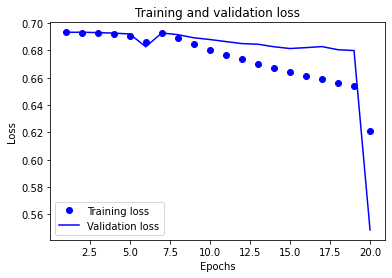

In [32]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

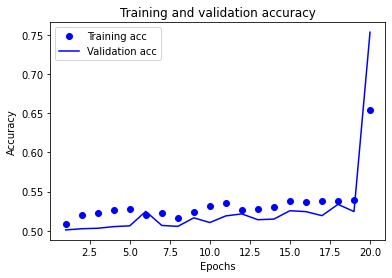

In [33]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## word2vec을 적용해보자: 워드임베딩 효과를 증대 = 임베딩 레이어에 학습된 워드 벡터들이 유의미하게 공간상에 표현되었는가?

In [34]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [37]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/workspace/sentimental_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
#gensim패키지 사용 - 임베딩 파라미터를 읽어서 word vector로 활용

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-0.15070055, -0.06290054, -0.03158965, -0.08576063, -0.11936969,
        0.08202324,  0.13164914,  0.07469115, -0.0868268 , -0.07699308,
       -0.12023365,  0.07731161, -0.12293761,  0.14352158,  0.09744259,
        0.12226139], dtype=float32)

In [39]:
word_vectors.similar_by_word("love")

[('alexandra', 0.9188196063041687),
 ('brutality', 0.9131999015808105),
 ('dashing', 0.9119632244110107),
 ('ought', 0.9107054471969604),
 ('glimpse', 0.9099799394607544),
 ('slavery', 0.9087499380111694),
 ('guide', 0.9080654382705688),
 ('remade', 0.906608521938324),
 ('dudley', 0.9027790427207947),
 ('nominated', 0.9027639031410217)]

In [41]:
# google에서 제공하는 word2vec이라는 워드임베딩모델을 가져온다!
# 300만 단어를 300차원의 벡터로 표현

from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/workspace/sentimental_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector.shape    # 무려 300dim의 워드 벡터.


(300,)

In [42]:
#300dim의 벡터로 이루어진 300만 개의 단어입니다. 
#이 단어 사전을 메모리에 모두 로딩하면 아주 높은 확률로 여러분의 실습환경에 메모리 에러가 날 것입니다. 
#그래서 KeyedVectors.load_word2vec_format 메서드로 워드 벡터를 로딩할 때 가장 많이 사용되는 상위 100만 개만 limt으로 조건을 주어 로딩했습니다.
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.

word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [43]:
# embedding layer를 word2vec으로 바꿔주기

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [44]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                     word_vector_dim, 
                                     embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                     input_length=maxlen, 
                                     trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [45]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 24s 187ms/step - loss: 0.6982 - accuracy: 0.5039 - val_loss: 0.6898 - val_accuracy: 0.5398
Epoch 2/20
30/30 [==============================] - 4s 138ms/step - loss: 0.6788 - accuracy: 0.5711 - val_loss: 0.6925 - val_accuracy: 0.5581
Epoch 3/20
30/30 [==============================] - 4s 140ms/step - loss: 0.6419 - accuracy: 0.6421 - val_loss: 0.6259 - val_accuracy: 0.6676
Epoch 4/20
30/30 [==============================] - 4s 139ms/step - loss: 0.5093 - accuracy: 0.7883 - val_loss: 0.4400 - val_accuracy: 0.8184
Epoch 5/20
30/30 [==============================] - 4s 139ms/step - loss: 0.3256 - accuracy: 0.8733 - val_loss: 0.3413 - val_accuracy: 0.8545
Epoch 6/20
30/30 [==============================] - 4s 141ms/step - loss: 0.2185 - accuracy: 0.9197 - val_loss: 0.3322 - val_accuracy: 0.8607
Epoch 7/20
30/30 [==============================] - 4s 141ms/step - loss: 0.1552 - accuracy: 0.9490 - val_loss: 0.3021 - val_accuracy: 0.8765
Epoch

In [46]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 2s - loss: 0.4732 - accuracy: 0.8649
[0.4732283651828766, 0.8649200201034546]
